# Idea
Where we describe how we'll do recommendations. We assume we have scrapped a good portion of past events, clustered them and have saved the centroids. We also assume we have this week's events embeddings.

This is also meant to be a playground to try out new ideas so it might be a little messy.

In [1]:
import requests, json, pickle, urllib, time, random, os
from bs4 import BeautifulSoup
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances

def softmax(x):
    e = (np.exp(x) - np.max(x, axis = 1, keepdims = True))
    e /= e.sum(axis = 1, keepdims = True)
    return e

In [3]:
# First load everything
centroids = np.load('../data/centroids.npy')
current_embs = np.load('../data/embeddings.npy')
with open('../data/cluster_data/kmeans_model.pkl', 'rb') as f: m = pickle.load(f)
with open('../data/cluster_data/to_embed.json', 'r') as f: to_embed = json.loads(f.read())
centroids.shape, current_embs.shape

/home/main/.local/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator KMeans from version 1.4.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


((1000, 1536), (698, 1536))

In [4]:
# Then compute the euclidian distances of new embeddings to the centroids
# Could do it manually but can use sklearn's optimized function
# Note: could also use m.transform(current_embs) but we could avoid loading the model this way
dists_to_centroids = euclidean_distances(current_embs, centroids)
dists_to_centroids.shape

(698, 1000)

In [6]:
# We'll weight how much each cluster can say about each event by how far away they are
eps = 1e-6 # in case a dist is exactly 0
inv_temp = 2
weights = (1 / (dists_to_centroids + eps))
weights = softmax(weights * inv_temp)
weights.shape

(698, 1000)

In [33]:
# We'll imagine that users "rate clusters". I.e. we'll maintain a (n_clusters,) vector "rating" each of the clusters
user_ratings = np.random.uniform(-1e-5, 1e-5, size = len(centroids))
user_ratings.shape

(1000,)

In [37]:
# Make predictions with
preds = (weights @ user_ratings)
preds.shape

(698,)

In [38]:
# Imagine user rated
rated_ix, rating = 0, 2 # event rated and rating given
preds[rated_ix]

np.float64(0.0021060817068293486)

In [39]:
# We update the user ratings with
lr = 1  # step size / lambda
user_ratings -= lr * weights[rated_ix] * (preds[rated_ix] - rating)

# After update
preds = weights @ user_ratings
preds[rated_ix]

np.float64(0.004209735926879975)

In [128]:
user_ratings = np.random.uniform(-1e-5, 1e-5, size = len(centroids))
rating_history = [user_ratings.copy()]

updated_ratings = lambda ratings, preds, rated_ix, actual: ratings - lr * weights[rated_ix] * (preds[rated_ix] - actual)

rated_ix = 10
closest_cluster = weights[rated_ix].argmax()  # to the event
furthest_cluster = weights[rated_ix].argmin() # from the event
furthest_event = euclidean_distances(current_embs, current_embs)[rated_ix].argmax()

# user rates the event positively
user_ratings = updated_ratings(user_ratings, preds, rated_ix, 2)
rating_history.append(user_ratings.copy())

# and downvotes the event that is furthest away
for _ in range(20):
    user_ratings = updated_ratings(user_ratings, preds, furthest_event, -1)
    rating_history.append(user_ratings.copy())


rating_history = np.stack(rating_history, axis = 1)
closest_cluster, furthest_cluster, rating_history.shape

(np.int64(781), np.int64(607), (1000, 22))

Text(0.5, 0, 'time step')

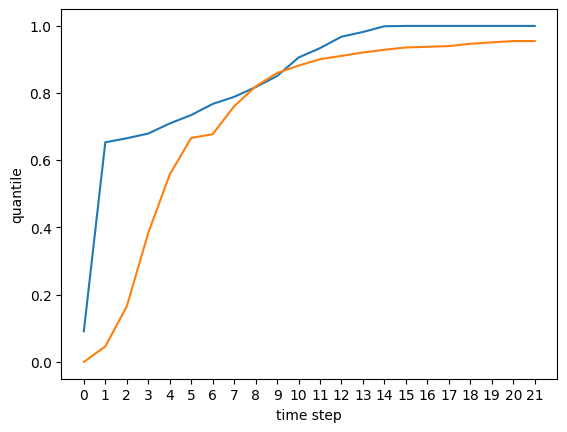

In [130]:
_ = plt.plot(np.where(rating_history.argsort(axis = 0) == closest_cluster)[0] / rating_history.shape[0])
_ = plt.plot(np.where(rating_history.argsort(axis = 0) == furthest_cluster)[0] / rating_history.shape[0])
_ = plt.xticks(np.arange(rating_history.shape[1]))
plt.ylabel('quantile'); plt.xlabel('time step')